In [1]:
#import directory and netcdf libs
import datetime as dt
from datetime import datetime
from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
import pandas
import matplotlib.pyplot as plt
import numpy as np
#import plotly
#import plotly.plotly as py
#from plotly.graph_objs import *
#!pip install geopy  #to install geopy use !pip install geopy but only run once
import geopy.distance

#set plotly credentials
#plotly.tools.set_credentials_file(username='cgentemann', api_key='7uYsbupVsAjAScD0Hb0O')

####################you will need to change some paths here!#####################
#list of input files
#F:\data\NASA_biophysical\aviso
filename_aviso='f:/data/NASA_biophysical/aviso/eddy_trajectory_19930101_20170106.nc'   #From AVISO  website
filename_cpr='f:/data/NASA_biophysical/cpr_data/All CPR Sample catalogue.xlsx'
filename_distance_land='f:/data/sst/jpl_mur/v4.1/distance_to_land_25km.nc' 
#list of output files
filename_northpac_eddies='F:/data/NASA_biophysical/aviso/eddy_trajectory_19930101_20170106_amazon.nc'
filename_cpr_eddy='F:/data/NASA_biophysical/collocated_data/eddy_cpr_data_amazon.nc'
filename_eddy='F:/data/NASA_biophysical/collocated_data/eddy_ranking_data_amazon.nc'
#################################################################################

#open the netcdf file full eddy database from AVISO
nc_fid = Dataset(filename_aviso, 'r')  
# Extract data from NetCDF file
time = nc_fid.variables['time'][:]
lats = nc_fid.variables['latitude'][:]  
lons = nc_fid.variables['longitude'][:]
speed_average = nc_fid.variables['speed_average'][:]
amplitude = nc_fid.variables['amplitude'][:]
speed_radius = nc_fid.variables['speed_radius'][:]
cyclonic_type = nc_fid.variables['cyclonic_type'][:]
track = nc_fid.variables['track'][:]   #eddy identification number  0 - 272045
observation_number = nc_fid.variables['observation_number'][:]
nc_fid.close()
max_eddy_index=len(track)  
print('total number of eddies in database:',max_eddy_index)


total number of eddies in database: 23086878


In [15]:
#use datetime delta feature to find year and day
#make sure lon is 0-360 for collocations since we are doing north pacific & cross dateline
date_1950 = dt.datetime(1950,1,1,0,0,0) # start date is 1/1/1950
year=[0] * (max_eddy_index)
idayjl=[0] * (max_eddy_index)
time64=[0] * (max_eddy_index)
for t in range(0,max_eddy_index):
    tem_date=date_1950+dt.timedelta(days=float(time[t]))  #create new time array that can be queried for year etc
    year[t]=tem_date.year
    idayjl[t]=tem_date.timetuple().tm_yday
    time64[t] = np.datetime64(str(tem_date.year)+'-'+str(tem_date.month).zfill(2)+'-'+str(tem_date.day).zfill(2))
    if lons[t] < -180.:
        lons[t]=lons[t]+360.
    if t < 5:
        print(year[t],idayjl[t])   
print('max and min lons', max(lons), min(lons))

1993 1
1993 2
1993 3
1993 4
1993 5
max and min lons 359.999 0.0


In [22]:
import xarray as xr
ds=xr.open_dataset(filename_aviso)
ds


<xarray.Dataset>
Dimensions:             (obs: 23086878)
Dimensions without coordinates: obs
Data variables:
    amplitude           (obs) float32 ...
    cyclonic_type       (obs) int8 ...
    latitude            (obs) float32 ...
    longitude           (obs) float32 ...
    observation_number  (obs) uint16 ...
    speed_average       (obs) float32 ...
    speed_radius        (obs) float32 ...
    time                (obs) object ...
    track               (obs) uint32 ...
Attributes:
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    title:                     Mesoscale Eddies in Altimeter Observations of SLA
    institution:               CNES/CLS in collaboration with Oregon State Un...
    project:                   SSALTO/DUACS
    creator_url:               http://www.aviso.altimetry.fr
    creator_email:             aviso@altimetry.fr
    license:                   http://www.aviso.altimetry.fr/fileadmin/docume...
    summary:                   This dataset con

In [25]:
ds['time_old']=ds.time[:]
ds['time']=time64

MergeError: unable to determine if these variables should be coordinates or not in the merged result: {'time'}

In [4]:
#cond = (lons>280) & (lons<320) & (lats>-10) & (lats<20) & (observation_number<1) & (totobs>25)
#plt.plot(lons[cond],lats[cond],'.')

In [ ]:
cond = (lons>280) & (lons<320) & (lats>-10) & (lats<20) & 
plt.plot(lons[cond],lats[cond],'.')

In [30]:
# this code identifies the eddies that have any data in 2000 to 2017 in the north pacific region
# the code sorts by eddy identification number after this so that if an eddy just passes through the north pacific
# we still save all the eddy location and time information

#find the maximum eddy identification integer
max_eddy_identification=max(track)
#create an array with 0/1 flag 0= default; 1 = it was in region of interest
npac_eddy=[0] * (max_eddy_identification+1)
for index in range(0,max_eddy_index):
    if (lons[index]>280) and (lons[index]<320) and (lats[index]>-10) and (lats[index]<20):
        index_npac=track[index]
        npac_eddy[index_npac]=1    #the array npac_eddy now has 1 if that eddy was in north pacific'
print('total number of eddies in north pacific',sum(npac_eddy),len(npac_eddy))



total number of eddies in north pacific 4399 272046


In [31]:
#create a new dataset where you only have eddies from ones that are in the north pacific after 2000
#totobs=[0] * (max_eddy_index)
#for t in range(0,272046):
#    cond = (track == track[t])
#    totobs[t]=cond.sum().data
    
print(npac_eddy[0],npac_eddy[272045-1])
time_new=[]
lats_new=[]
lons_new=[]
amplitude_new=[]
speed_radius_new=[]
speed_average_new=[]
cyclonic_type_new=[]
track_new=[]
observation_number_new=[]
year_new=[]
idayjl_new=[]
for index in range(0,max_eddy_index):
    index_npac=track[index]  #check the track id for the eddy & if it is in north pacific
    if index_npac>272045:
        print(index_npac)
    if npac_eddy[index_npac]==1:
        time_new.append(time[index])
        lats_new.append(lats[index])
        lons_new.append(lons[index])
        amplitude_new.append(amplitude[index])
        speed_average_new.append(speed_average[index])
        speed_radius_new.append(speed_radius[index])
        cyclonic_type_new.append(cyclonic_type[index])
        track_new.append(track[index])
        observation_number_new.append(observation_number[index])
        year_new.append(year[index])
        idayjl_new.append(idayjl[index])
        

0 0


In [ ]:
print(len(time_new))

In [32]:
#eddy_id is from AVISO so it starts at 79110 and goes to 272035 but not
#sequentially since I downsampled the data.  Here I calucalte a new eddy
#index that goes from 1 to N sequentially
#this isn't used here, but could be used to go through all the eddies

#first go through data and save a new eddy id for each first observation
ilen_eddy=len(lons_new)
track_npac=0
print(max(track_new))
track_npac_new=[0] * (max(track_new)+1)
track_npac_new_array=[0] * (ilen_eddy+1)
for index in range(0,ilen_eddy):
    if observation_number_new[index]==0:
        track_npac=track_npac+1
        track_npac_new[track_new[index]]=track_npac
max_new_eddy_number = track_npac
new_length_eddy = [0] * (max_new_eddy_number+1)
#now go through data and assign new track id for all observations
for index in range(0,ilen_eddy):
    itrack=track_npac_new[track_new[index]]
    track_npac_new_array[index]=itrack
#find all the eddies that match new eddy number to determine length of each eddy
for ieddy_num in range(1,max_new_eddy_number):
    new_list=[index for index, x in enumerate(track_npac_new_array) if x==ieddy_num] 
    new_length_eddy[ieddy_num]=len(new_list)

272021


In [33]:
track_npac_new_array_length=[0]*(ilen_eddy)
for index in range(0,ilen_eddy):
    ieddy=track_npac_new_array[index]
    ilen=new_length_eddy[ieddy]
    track_npac_new_array_length[index]=ilen
print('done')

done


In [34]:
inum_obs=len(idayjl_new)
f = Dataset(filename_northpac_eddies,'w', format='NETCDF4') 
#tempgrp = f.createGroup('Eddy_data')
f.createDimension('z', inum_obs)
lons_netcdf = f.createVariable('Longitude', 'f4', 'z')
lats_netcdf = f.createVariable('Latitude', 'f4', 'z')  
time_netcdf = f.createVariable('time', 'i4', 'z')
amplitude_netcdf = f.createVariable('amplitude', 'f4', 'z')
speed_average_netcdf = f.createVariable('speed_average', 'f4', 'z')
speed_radius_netcdf = f.createVariable('speed_radius', 'f4', 'z')
cyclonic_type_netcdf = f.createVariable('cyclonic_type', 'i1', 'z')
track_netcdf = f.createVariable('track', 'i4', 'z')
track_days_netcdf = f.createVariable('track_total_days', 'i4', 'z')
observation_number_netcdf = f.createVariable('observation_number', 'i2', 'z')
year_netcdf = f.createVariable('year', 'f4', 'z')
idayjl_netcdf = f.createVariable('idayjl', 'f4', 'z')
lons_netcdf[:] = lons_new
lats_netcdf[:] = lats_new
time_netcdf[:] = time_new
amplitude_netcdf[:] = amplitude_new
speed_average_netcdf[:] = speed_average_new
speed_radius_netcdf[:] = speed_radius_new
track_netcdf[:] = track_new
observation_number_netcdf[:] = observation_number_new
year_netcdf[:] =year_new
idayjl_netcdf[:] = idayjl_new
track_days_netcdf[:]=track_npac_new_array_length
lons_netcdf.units = 'degrees east'
lats_netcdf.units = 'degrees north'
time_netcdf.units = 'days since 1950-01-01 00:00:00 UTC'
amplitude_netcdf.units = 'cm'
speed_average_netcdf.units = 'cm/s'
speed_radius_netcdf.units = 'km'
cyclonic_type_netcdf.units = 'cyclonic -1; anti-cyclonic +1'
track_netcdf.units = 'eddy identification number'
track_days_netcdf.units = 'total number of days eddy identified'
observation_number_netcdf.units = 'observation sequence number, days from start'
f.close()

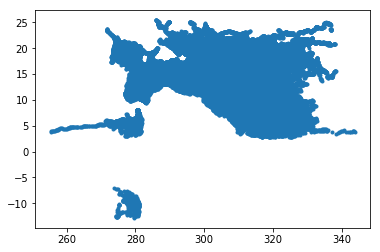

In [35]:
plt.plot(lons_new,lats_new,'.')